# Assignment 06
EE 538 Spring 2020 <br>
Analog Circuits for Sensor Systems <br>
University of Washington Electrical & Computer Engineering <br>

Due: May 23, 2020 <br>
Author: Kevin Egedy

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

<img src="images/HW06Q1.png" width="700">

**Input-Referred Voltage Noise**

<img src="images/input_voltage_noise.png" width="300">

<hr>

**Input Resistor Noise**

<img src="images/input_resistor_noise.png" width="300">

$$\begin{eqnarray}
&& e_{n1,out} &=& \frac{-R_2}{R_1}e_{n1} \\[0.5em]
&& e_{n1,out}^2 &=& (\frac{R_2}{R_1})^2 4kTR_1 && \frac{V^2}{\text{Hz}}
\end{eqnarray}$$

<hr>

**Feedback Resistor Noise**

<img src="images/feedback_resistor_noise.png" width="300">

$$\begin{eqnarray}
&& e_{n2,out} &=& e_{n2} \\[0.5em]
&& e_{n2,out}^2 &=& 4kTR_2 && \frac{V^2}{\text{Hz}}
\end{eqnarray}$$

<hr>

**Opamp Noise**

<img src="images/opamp_noise.png" width="300">

$$\begin{eqnarray}
&& e_{n,out} &=& (1+\frac{R_2}{R_1})e_{na} \\[0.5em]
&& e_{na,out}^2 &=& (1+\frac{R_2}{R_1})^2 e_{na}^2 && \frac{V^2}{\text{Hz}}
\end{eqnarray}$$

<hr>

**Part A**

**Given**: $e_n = \frac{10nV}{\sqrt{\text{Hz}}}, i_n = \frac{1pA}{\sqrt{\text{Hz}}}, f_T = 10\text{MHz}, kT = 4.1145e-21$

$\begin{eqnarray}
&& A_V &=& \frac{1}{\beta} = \frac{-R_f}{R_i} = 10 \\[0.5em]
&& e_{n,out}^2 &=& (\frac{R_f}{R_i})^2 4kTR_i + 4kTR_f + (1+\frac{R_f}{R_i})^2 e_n^2 + (i_n R_f)^2 \\[0.5em]
&& e_{n,out} &=& \sqrt{(\frac{R_f}{R_i})^2 4kTR_i + 4kTR_f + 
(1+\frac{R_f}{R_i})^2 e_n^2 + (i_n R_f)^2} \\[0.5em]
&& e_{n,out} &=& 1.18365 \cdot 10^{-7} \frac{V}{\sqrt{\text{Hz}}} \\[0.5em]
&& e_{n,in} &\approx& \frac{e_{n,out}}{1/\beta} \\[0.5em]
&& e_{n,in} &=& 1.18365 \cdot 10^{-8} \frac{V}{\sqrt{\text{Hz}}}
\end{eqnarray}$

<hr>

**Part B**

$\begin{eqnarray}
&& A_V &=& \frac{1}{\beta} = \frac{-R_f}{R_i} = 10 \\[0.5em]
&& f_{ENB} &=& \frac{\pi}{2} f_{3dB}  = \frac{\pi}{2} \beta f_T 
\approx 157 \cdot 10^6 \text{Hz} \\[0.5em]
&& v_{n,out(rms)} &=& \sqrt{e_{n,out}^2 \frac{\pi}{2}\beta f_T}  = 
   \sqrt{e_{n,out}^2 f_{ENB}}\\[0.5em]
&& v_{n,in(rms)} &\approx& \frac{v_{n,out(rms)}}{1/\beta} \\[0.5em]
&& &=& \beta \sqrt{e_{n,out}^2 \frac{\pi}{2}f_T} \\[0.5em]
&& &=& \frac{1}{10} \sqrt{(1.18365 \cdot 10^{-7})^2 (157 \cdot 10^6)} =
       0.0001483 \frac{V}{\sqrt{\text{Hz}}} \\[0.5em]
\end{eqnarray}$

<hr>

**Part C**

<img src="images/HW06Q1_Ltspice.png" width="500">

In [14]:
filepath = 'data/fb_amp_noise.txt'
df = pd.read_csv(filepath)
freq = df['frequency']
mag1 = df['V(inoise)']
mag2 = df['V(onoise)']

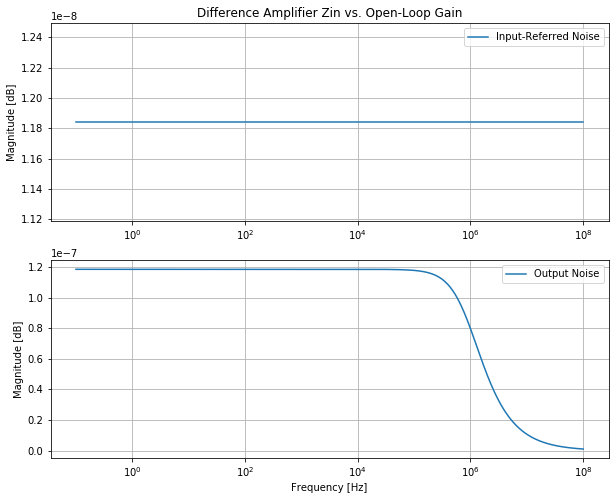

In [15]:
#Plot
fig, axs = plt.subplots(2,figsize=(10,8))
axs[0].set_title('Difference Amplifier Zin vs. Open-Loop Gain')
axs[0].semilogx(freq, mag1, label='Input-Referred Noise')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].grid()
axs[0].legend()
axs[1].semilogx(freq, mag2, label='Output Noise')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Magnitude [dB]')
axs[1].grid()
axs[1].legend()
plt.show();

<img src="images/HW06Q2.png" width="700">

**Part A**

$$\begin{align}
  \begin{array}{ll}
 f_{3dB} \approx \beta f_T && f_{\text{ENB}} = \frac{\pi}{2}f_{3dB}
  \end{array}
\end{align}$$